# Run Train of Bubble-Agent (w/ IQN9)

- Team: TToBoT
- Member: { Sejun, Steve, Victor } @kaist

## Objective

- run training simultaneously w/ notebook

**[strategy]**
1. (limited) train agent per each stage-level
   - only 1 life (due to invincible respawn)
   - 1~2 iteration per stage+1
2. random stage-level, enumerate all stages. train w/ 1 life
   - average reward/score/clearance per level.
3. hard train on weakness levels (w/ 1 life)
4. hard train on 10 hard levels (w/ 3 life)


## History

- based on `iqn7` iteration 200. copied to `iqn9`
- bonus reward if got score
- no use 'double_dqn'
- step_penalty = 0.0005 in order to encourage survival.
- enumerate each level. (from 1 to 50)


In [1]:
import os, sys, gin

# use parent folder as shared lib path..
if "../" not in sys.path:
    sys.path.append("../")

# major libraries
import gin.tf
import seaborn as sns
import matplotlib.pyplot as plt
from absl import flags
import numpy as np
import tensorflow as tf

# show tf version.
print('! tf.ver = {}'.format(tf.__version__))

! tf.ver = 1.15.2


In [2]:
# let Dopamine .py files to be imported as modules in Jupiter notebook
module_path = os.path.abspath(os.path.join('../dopamine'))
if module_path not in sys.path:
    sys.path.append(module_path)
    print(module_path)

/tf/dopamine


In [3]:
# try to load `Dopamine` libraries
from dopamine.colab import utils as colab_utils
from dopamine.discrete_domains import run_experiment
import bubble
import time, datetime
current_msec = lambda: int(round(time.time() * 1000))
current_time = lambda: str(datetime.datetime.now())[0:19]

## Train Bubble w/ IQN

In [4]:
# @title Load the configuration for IQN.

# DQN_PATH = os.path.join(BASE_PATH, 'rainbow')
# Modified from dopamine/agents/implicit_quantile/config/implicit_quantile.gin
GAME_LEVEL = 1

# CONFIG FOR IQN (see @bubble/iqn_nature.gin)
# - with the network trained for 200x. minized epsilon.
gin_config = '''
# run train for bubble agent
# - NOTE: customized for bubble w/ IQN
# - origin from `dopamine/agents/implicit_quantile/configs/implicit_quantile.gin`
#
# [RUN TRAIN]
# $ python -um dopamine.discrete_domains.train --base_dir=/tmp/bubble_iqn1 --gin_files='bubble/iqn_bubble.gin' --gin_bindings='RainbowAgent.tf_device="/cpu:*"'

# Hyperparameters follow Dabney et al. (2018), but we modify as necessary to
# match those used in Rainbow (Hessel et al., 2018), to ensure apples-to-apples
# comparison.
import dopamine.agents.implicit_quantile.implicit_quantile_agent
import dopamine.agents.rainbow.rainbow_agent
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
import dopamine.replay_memory.prioritized_replay_buffer
import gin.tf.external_configurables

# agent for bubble
import bubble.retro_lib
import bubble.bubble_agent
retro_lib.create_retro_environment.game_name = 'BubbleBobble'
retro_lib.create_retro_environment.level = {}
Runner.create_environment_fn = @retro_lib.create_retro_environment
create_agent.agent_name = 'implicit_quantile'
RetroPreprocessing.wall_offset = 0          # use 200 if activate
#RetroPreprocessing.step_penalty = -0.0001  # every step penalty
RetroPreprocessing.step_penalty = 0.0005    # every step penalty (survival is better since 200623/443)
RetroPreprocessing.reset_fire = 0
RetroPreprocessing.score_bonus = 0.02       # bonus reward if got new-score.

ImplicitQuantileAgent.kappa = 1.0
ImplicitQuantileAgent.num_tau_samples = 64
ImplicitQuantileAgent.num_tau_prime_samples = 64
ImplicitQuantileAgent.num_quantile_samples = 32
# ImplicitQuantileAgent.double_dqn = True   # NOTE - default is False
RainbowAgent.gamma = 0.99
RainbowAgent.update_horizon = 3
RainbowAgent.min_replay_history = 20000 # agent steps
RainbowAgent.update_period = 4
RainbowAgent.target_update_period = 8000 # agent steps

RainbowAgent.epsilon_train = 0.001
RainbowAgent.epsilon_eval = 0.001
RainbowAgent.epsilon_decay_period = 200000  # agent steps (1 at step=1 => 0.001 at step=200000)

# IQN currently does not support prioritized replay.
RainbowAgent.replay_scheme = 'uniform'
RainbowAgent.tf_device = '/gpu:0'  # '/cpu:*' use for non-GPU version
RainbowAgent.optimizer = @tf.train.AdamOptimizer()

tf.train.AdamOptimizer.learning_rate = 0.00005
tf.train.AdamOptimizer.epsilon = 0.0003125

Runner.num_iterations = 600
Runner.training_steps = 200000             # origin 250000
Runner.evaluation_steps = 0
Runner.max_steps_per_episode = 20000       # origin 27000

WrappedPrioritizedReplayBuffer.replay_capacity = 1000000
WrappedPrioritizedReplayBuffer.batch_size = 32
'''.format(GAME_LEVEL)

# parse this config
gin.parse_config(gin_config, skip_unknown=False)


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
# Train History..
#dqn4 (5/28) - reward := -0.01 + 1*K - 3*D + log(S,100) + 5*L
#iqn7 (6/04) - final reward
#iqn8 (6/11) - wall filtering  (copied via iqn7)
#iqn8 (6/17) - no wall-filter, starts from 44 level. (iter = 300~400)
#iqn8 (6/25) - +1 max 50 w/ 3 lives. (i=479, l=11)
#iqn8 (6/26) - map 200 to 1L.
DQN_PATH = '/tmp/bubble_iqn9'    # 5 -> wall_offset = 0

# config main file
gin_files = []
gin_bindings = ['Runner.evaluation_steps=10000']

## Thread for updating status

In [6]:
# Thread for update canvas
import threading, time
def get_ioloop():
    import IPython, zmq
    ipython = IPython.get_ipython()
    if ipython and hasattr(ipython, 'kernel'):
        return zmq.eventloop.ioloop.IOLoop.instance()
# The IOloop is shared
ioloop = get_ioloop()

# Main Thread
class MyThread(threading.Thread):
    '''Thread for drawing into canvas in live'''
    def __init__(self, sleep = 0.5, name = 'my'):
        super().__init__()
        self._quit = threading.Event()
        self.sleep = 0.5
        self.name = name
        self.start()    
    def run(self):
        while not self._quit.isSet():
            def update_progress():
                if self._quit.isSet():
                    return
                self.display()
            time.sleep(self.sleep)
            ioloop.add_callback(update_progress)
        print("! T[{}].Quit()".format(self.name))
    def quit(self):
        self._quit.set()
    def display(self):
        pass

# draw to canvas
def drawPlot2Canvas(fig = None, x=0, y=0):
    '''draw current plt to canvas at (x,y)'''
    global canvas
    fig = plt.gcf() if fig is None else fig
    plt.close()          # not to update on screen.
    fig.canvas.draw()    # draw fig to canvas
    arr = np.array(fig.canvas.renderer._renderer)
    print('! arr = {}'.format(np.shape(arr)))
    h, w, d = np.shape(arr)
    print('! w,h,d = {}'.format(w))
    cv = Canvas(width=w, height=h)
    cv.put_image_data(arr, 0, 0)
    cv.stroke_rect(x,y, x+w-1, y+h-1)
    canvas.clear_rect(x,y, x+w, y+h)
    canvas.draw_image(cv, x, y)

# text to canvas
def drawText2Canvas(txt='msg!', x=10, y=10):
    global canvas
    w,h,o = 200,10,10
    canvas.clear_rect(x, y-o, x+w, y+h-o)
    canvas.stroke_text(txt, x, y)

# # display basic 
# from ipycanvas import Canvas
# canvas = Canvas(width=640, height=480)
# if canvas:
#     canvas.stroke_text('hello canvas! -------------', 0, 10)
# # show canvas in here.
# canvas

In [ ]:
# draw plot-to-canvas
#drawPlot2Canvas(fig, x=0)
# drawText2Canvas('hello world')

### support Multi-Processing

In [7]:
from multiprocessing import Process, Queue
# train function
def processTrain(name = 'train', Q = None):
    global gin_files, gin_bindings, DQN_PATH
    from dopamine.discrete_domains import run_experiment
    Q.put('init!') if Q else None
    tf.logging.set_verbosity(tf.logging.INFO)
    run_experiment.load_gin_configs(gin_files, gin_bindings)
    runner = run_experiment.create_runner(DQN_PATH)
    # access to env
    env = runner._environment
    o = env.reset()
    Q.put('! o({}) = {}'.format(type(o), o[0:10,0,]))
    Q.put('start!') if Q else None
    runner.run_experiment()
    Q.put('! P[{}].stop()'.format(name))

# train thread
def startProcessTrain(target = None):
    global proc_queue, proc_list
    target = target if target is not None else processTrain
    proc_queue = Queue() if proc_queue is None else proc_queue
    proc = Process(target = target, args = ('T0', proc_queue))
    proc_list.append(proc)
    proc.start()
    return proc

# stop(or kill) processes
def stopProcess():
    global proc_list
    for proc in proc_list:
        t = proc.terminate()
        proc.join()
        print('! terminated = {}'.format(t))
    proc_list = []

# MyThread for status display
class MyTrainStatus(MyThread):
    draw_to_plot = True
    def __init__(self):
        super().__init__(name='status')
        self.episodes = np.array([[0,0]])
        self.game_level = 0
        print('! MyTrainStatus({})'.format(self.name))
    def display(self):
        global canvas, proc_queue, plt
        episodes = []
        # pop all queue...
        while not proc_queue.empty():
            msg = proc_queue.get()
            if msg and 'episode' in msg:
                E = msg['episode']
                episodes.append([E['length'], E['return']])
            elif msg and 'phase' in msg:
                P = msg['phase']
                self.game_level = P['level']
                self.episodes = np.array([[0,0]])  # reset
        # draw plot if len > 0
        if len(episodes) > 0:
            arr = np.array(episodes)
            # draw to plot...
            if MyTrainStatus.draw_to_plot:
                self.episodes = np.vstack((self.episodes, arr))
                fig, ax1 = plt.subplots()
                ax2 = ax1.twinx()
                ax1.plot(self.episodes[:,0], 'g-')
                ax2.plot(self.episodes[:,1], 'b-')
                ax1.set_xlabel('Episode[L{}] Count'.format(self.game_level))
                ax1.set_ylabel('Length', color='g')
                ax2.set_ylabel('Return', color='b')
                drawPlot2Canvas(fig)
            else:
                print('>> episode[L{}] = {}'.format(self.game_level, arr))

In [8]:
# process list in global
proc_list = []
proc_queue = None

### MyTrainer and MyThread

In [9]:
from dopamine.discrete_domains import run_experiment
from dopamine.agents.implicit_quantile import implicit_quantile_agent
from bubble import bubble_agent
from bubble import bubble_runner

# MyRunner for Train
class MyBubbleIQNRunner(bubble_runner.BubbleRunner):
    def __init__(self, base_dir, create_agent_fn, proc_queue = None, game_level = 0):
        '''MyRunner: reporting score in log'''
        super(MyBubbleIQNRunner, self).__init__(base_dir, create_agent_fn, proc_queue = proc_queue)
        self.end_on_death = False
        self.game_level = game_level
    def post_message(self, data):
        self.proc_queue.put(data) if self.proc_queue is not None else None
    def _initialize_episode(self):
        env = self._environment
        obs = env.reset(self.game_level) if self.game_level > 0 else env.reset()
        return self._agent.begin_episode(obs)
    def _run_one_step(self, action):
        observation, reward, is_terminal, info = self._environment.step(action)
        return observation, reward, is_terminal, info
    def _run_one_episode(self):
        step_number = 0
        total_reward = 0.
        agent_lives = 0
        action = self._initialize_episode()
        is_terminal = False
        is_death = False
        # Keep interacting until we reach a terminal state.
        while True:
            observation, reward, is_terminal, info = self._run_one_step(action)
            curr_lives = int(info['lives']) if 'lives' in info else 0
            total_reward += reward
            step_number += 1
            #! end the episode if death.
            is_death = True if curr_lives < agent_lives else is_death
            agent_lives = curr_lives
            #! determine terminal & EOE
            if (self.end_on_death and is_death):
                break
            # TODO(steve) - need to clip reward really?!!
            reward = np.clip(reward, -1, 1)
            if (self._environment.game_over or step_number == self._max_steps_per_episode):
                break
            elif is_terminal:
                self._agent.end_episode(reward)
                action = self._agent.begin_episode(observation)
            else:
                action = self._agent.step(reward, observation, info)
        self._end_episode(reward)
        #! report status and returns
        self.post_message({'episode': {'length': step_number, 'return': total_reward}})
        return step_number, total_reward, int(info['score']), int(info['level'])
    def _run_one_phase(self, min_steps, statistics, run_mode_str):
        step_count = 0
        num_episodes = 0
        sum_returns = 0.
        time_started = current_msec()
        self.post_message({'phase': {'steps': min_steps, 'mode': run_mode_str, 'level':self.game_level }})
        while step_count < min_steps:
            episode_length, episode_return, episode_score, episode_level = self._run_one_episode()
            statistics.append({
              '{}_episode_lengths'.format(run_mode_str): episode_length,
              '{}_episode_returns'.format(run_mode_str): episode_return
            })
            step_count += episode_length
            sum_returns += episode_return
            num_episodes += 1
            sec_per_step = ((current_msec() - time_started)/1000.0/step_count)
            sec_remained = int((min_steps - step_count)*sec_per_step)
            time_display = '{:1.1f}m'.format(sec_remained/60) if sec_remained > 60*5 else '{}s'.format(sec_remained)
            sys.stdout.write('Steps: {:6.0f} {:2.0f}% '.format(step_count, step_count/min_steps*100.) +
                           'Remains: {} '.format(time_display) +
                           'Episode[{}].len: {} '.format(num_episodes, episode_length) +
                           'Return: {:.1f} S:{} L:{}'.format(episode_return, episode_score, episode_level)+ 
                           '         \r')
            sys.stdout.flush()
        return step_count, sum_returns, num_episodes
    def _run_one_iteration(self, iteration):
        global current_time
        # MAP Iteration to LEVEL @200626 (545 -> 25)
        #self.game_level = ((int(iteration) - 545 + 24) % 50) + 1
        self.game_level = ((int(iteration) - 200 + 0) % 50) + 1
        print('{} - run_one_iteration({}) - L{}'.format(current_time(), iteration, self.game_level))
        ret = super(MyBubbleIQNRunner, self)._run_one_iteration(iteration)
        return ret

# MyAgent for Train
class MyBubbleIQNAgent(implicit_quantile_agent.ImplicitQuantileAgent):
    """Sample MyBubbleIQNAgent agent based on IQN"""
    def __init__(self, sess, num_actions, summary_writer=None):
        print('! MyBubbleIQNAgent(%s)' % (num_actions))
        super(MyBubbleIQNAgent, self).__init__(sess, num_actions, summary_writer=summary_writer)
    def step(self, reward, observation, info = None):
        return super(MyBubbleIQNAgent, self).step(reward, observation)
    def get_probabilities(self):
        return self._sess.run(tf.squeeze(self._net_outputs.probabilities),{self.state_ph: self.state})

# create agent.
def my_create_agent(sess, environment, summary_writer=None):
    return MyBubbleIQNAgent(sess, num_actions=environment.action_space.n, summary_writer=summary_writer)

#! start runner
def startMyRunner(name = 'train', Q = None):
    global gin_files, gin_bindings, DQN_PATH, proc_queue
    from dopamine.discrete_domains import run_experiment
    Q.put('! start: my-runner') if Q else None
    tf.logging.set_verbosity(tf.logging.INFO)
    run_experiment.load_gin_configs(gin_files, gin_bindings)
    #runner = MyRunner(DQN_PATH, run_experiment.create_agent)
    #runner = MyRunner(DQN_PATH, bubble_agent.create_bubble_iqn_agent)
    runner = MyBubbleIQNRunner(DQN_PATH, my_create_agent, proc_queue, game_level=GAME_LEVEL)
    runner.run_experiment()
    Q.put('! P[{}].stop()'.format(name)) if Q else None

#! start process of runner
startProcessTrain(target = startMyRunner)

<Process(Process-1, started)>

! BubbleRunner(/tmp/bubble_iqn9)
INFO:tensorflow:------------------------------------------------------------------------------------------------
INFO:tensorflow:BubbleRunner() starts!!
INFO:tensorflow:------------------------------------------------------------------------------------------------
! create_retro_environment: BubbleBobble/1
INFO:tensorflow:Create RetroGame:BubbleBobble-Nes w/ stage:Level01
! RetroPreprocessing: wall_offset=0, step_penalty=0.0005, game_level=1, reset_fire=0, score_bonus=0.02
! MyBubbleIQNAgent(6)
INFO:tensorflow:Creating MyBubbleIQNAgent agent with the following parameters:
INFO:tensorflow:	 gamma: 0.990000
INFO:tensorflow:	 update_horizon: 3.000000
INFO:tensorflow:	 min_replay_history: 20000
INFO:tensorflow:	 update_period: 4
INFO:tensorflow:	 target_update_period: 8000
INFO:tensorflow:	 epsilon_train: 0.001000
INFO:tensorflow:	 epsilon_eval: 0.001000
INFO:tensorflow:	 epsilon_decay_period: 200000
INFO:tensorflow:	 tf_device: /gpu:0
INFO:tensorflow:	 us

INFO:tensorflow:Average undiscounted return per training episode: -0.2039 L:9          
INFO:tensorflow:Average training steps per second: 77.77
INFO:tensorflow:Average undiscounted return per evaluation episode: -1.18:9         
2020-06-29 04:07:46 - run_one_iteration(259) - L10
INFO:tensorflow:Starting iteration 259
INFO:tensorflow:Create RetroGame:BubbleBobble-Nes w/ stage:Level10
INFO:tensorflow:Average undiscounted return per training episode: -10.94 L:10           
INFO:tensorflow:Average training steps per second: 77.74
INFO:tensorflow:Average undiscounted return per evaluation episode: -12.550         
2020-06-29 04:58:06 - run_one_iteration(260) - L11
INFO:tensorflow:Starting iteration 260
INFO:tensorflow:Create RetroGame:BubbleBobble-Nes w/ stage:Level11
INFO:tensorflow:Average undiscounted return per training episode: -5.2341 L:11           
INFO:tensorflow:Average training steps per second: 77.45
INFO:tensorflow:Average undiscounted return per evaluation episode: -2.69:11  

INFO:tensorflow:Average undiscounted return per training episode: -12.282 L:30           
INFO:tensorflow:Average training steps per second: 79.86
INFO:tensorflow:Average undiscounted return per evaluation episode: -10.5330         
2020-06-29 22:03:16 - run_one_iteration(280) - L31
INFO:tensorflow:Starting iteration 280
INFO:tensorflow:Create RetroGame:BubbleBobble-Nes w/ stage:Level31
INFO:tensorflow:Average undiscounted return per training episode: -5.562 L:31            
INFO:tensorflow:Average training steps per second: 79.84
INFO:tensorflow:Average undiscounted return per evaluation episode: -2.6032         
2020-06-29 22:52:22 - run_one_iteration(281) - L32
INFO:tensorflow:Starting iteration 281
INFO:tensorflow:Create RetroGame:BubbleBobble-Nes w/ stage:Level32
INFO:tensorflow:Average undiscounted return per training episode: -13.327 L:32          
INFO:tensorflow:Average training steps per second: 80.16
INFO:tensorflow:Average undiscounted return per evaluation episode: -13.443

INFO:tensorflow:Average undiscounted return per training episode: -3.4362 L:3           
INFO:tensorflow:Average training steps per second: 77.75
INFO:tensorflow:Average undiscounted return per evaluation episode: 4.42 L:3         
2020-06-30 15:15:32 - run_one_iteration(301) - L2
INFO:tensorflow:Starting iteration 301
INFO:tensorflow:Create RetroGame:BubbleBobble-Nes w/ stage:Level02
INFO:tensorflow:Average undiscounted return per training episode: 9.01:1540 L:5         
INFO:tensorflow:Average training steps per second: 77.78
INFO:tensorflow:Average undiscounted return per evaluation episode: 13.61L:5         
2020-06-30 16:05:52 - run_one_iteration(302) - L3
INFO:tensorflow:Starting iteration 302
INFO:tensorflow:Create RetroGame:BubbleBobble-Nes w/ stage:Level03
INFO:tensorflow:Average undiscounted return per training episode: 7.941119 L:5          
INFO:tensorflow:Average training steps per second: 77.58
INFO:tensorflow:Average undiscounted return per evaluation episode: 8.02L:5   

In [10]:
from ipycanvas import Canvas
canvas = Canvas(width=640, height=480)
canvas

Canvas(height=480, width=640)

In [11]:
#! start thread for status
tstatus = MyTrainStatus()

! MyTrainStatus(status)


In [ ]:
MyTrainStatus.draw_to_plot = True if 1>0 else False

In [ ]:
episode_length, episode_return = 1,3
msg = {'episode':{'length': episode_length, 'return': episode_return }}
proc_queue.put(msg)
print('> msg.org = {}'.format(msg))

In [17]:
# stop - thread of status
tstatus.quit() if tstatus else None

! T[status].Quit()


In [18]:
# stop - process of train
stopProcess()

! terminated = None


## Exploration

In [ ]:
def showEpsilonDecaying(epsilon_decay_period=250000, min_replay_history=20000, epsilon_train=0.01, max_steps=250000):
    from dopamine.agents.dqn import dqn_agent
    F = lambda step: dqn_agent.linearly_decaying_epsilon(epsilon_decay_period,step,min_replay_history,epsilon_train)
    X = np.arange(1, max_steps, 100)
    Y = np.array([F(x) for x in X])
    fig = plt.figure(1)
    plot = fig.add_subplot(111)
    ax1 = plot.axes
    ax1.plot(Y, 'g-')
    ax1.set_xlabel('X data')
    ax1.set_ylabel('Y1 data', color='g')
    plt.show()

# plot epsilon decaying..
showEpsilonDecaying(epsilon_train=0.001, epsilon_decay_period=200000, max_steps=200000)

## Generate Video w/ same config

In [ ]:
class _FLAGS:
    agent = 'iqn'
    game = 'BubbleBobble'
    level = 1 if 0>0 else GAME_LEVEL
    num_steps = 200
    root_dir = '/tmp/bubble/'
    restore_ckpt = '/tmp/bubble_iqn8/checkpoints/tf_ckpt-223'
    use_legacy_checkpoint = False

class MyBubbleRunner(bubble_agent.MyBubbleRunner):
    def __init__(self, base_dir, trained_agent_ckpt_path, create_agent_fn, use_legacy_checkpoint = False):
        print('! MyBubbleRunner({})'.format(base_dir))
        super(MyBubbleRunner, self).__init__(base_dir, trained_agent_ckpt_path, create_agent_fn, use_legacy_checkpoint)

class MyBubbleAgent(bubble_agent.MyBubbleIQNAgent):
    def __init__(self, sess, num_actions, summary_writer=None):
        print('! MyBubbleAgent(%s)' % (num_actions))
        super(MyBubbleAgent, self).__init__(sess, num_actions, summary_writer=summary_writer)
    def get_probabilities(self):
        return self._sess.run(tf.squeeze(self._net_outputs.quantile_values), {self.state_ph: self.state})

def my_create_bubble_agent(sess, environment, summary_writer=None):
    return MyBubbleAgent(sess, num_actions=environment.action_space.n, summary_writer=summary_writer)

def main(FLAGS, postfix = 'viz', start = True):
    global gin_config
    from bubble import bubble_agent
    base_dir = os.path.join(FLAGS.root_dir, '{}_{}{}'.format(FLAGS.agent, postfix, FLAGS.level), FLAGS.game)
    print('! base_dir = {}'.format(base_dir))
    # start only if true
    if start:
        # 0. load config
        gin.parse_config(gin_config, skip_unknown=False)
        # 1. create runner.
        # runner = bubble_agent.create_runner(base_dir, FLAGS.restore_ckpt, FLAGS.agent, FLAGS.use_legacy_checkpoint)
        runner = MyBubbleRunner(base_dir, FLAGS.restore_ckpt, my_create_bubble_agent, FLAGS.use_legacy_checkpoint)
        runner._environment.reset(FLAGS.level)
        # 2. exec visualize().
        runner.visualize(os.path.join(base_dir, 'images'), num_global_steps=FLAGS.num_steps)
    # 3. return.
    return base_dir

# run....
viz_base_dir = main(_FLAGS(), postfix = 'viz', start = 0>0)
plt.close()

In [ ]:
#viz_base_dir = '/tmp/bubble/iqn_viz3/BubbleBobble'
from ipywidgets import Video
Video.from_file('{}/images/video.mp4'.format(viz_base_dir))
# Video.from_file('/tf/generate_video/video/agent_viz/BubbleBooble/iqn/images/video.mp4')

In [ ]:
from ipywidgets import Image
Image.from_file('{}/images/frame_000190.png'.format(viz_base_dir))

## Rewards Graph

In [15]:
# Load the training logs (DQN)
import seaborn as sns
from dopamine.colab import utils as colab_utils
def showRewardPerIterationGraph(agents, value = 'train_average_return'):
    fig, ax = plt.subplots(figsize=(11,7))
    COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for i in range(len(agents)):
        agent = agents[i]
        data1 = colab_utils.read_experiment('/tmp/bubble_{}'.format(agent)
                                            , verbose=True
                                            , summary_keys=['train_episode_returns', 'train_average_return', 'eval_average_return'])
        data1['agent'] = agent
        data1['run'] = 1
        # Plot training results
        sns.tsplot(data=data1, time='iteration', unit='run'
                   , condition='agent', value=value, ax=ax, color=COLORS[i])
    plt.title('BubbleBobble')
    plt.show()

Reading statistics from: /tmp/bubble_iqn9//logs/log_304


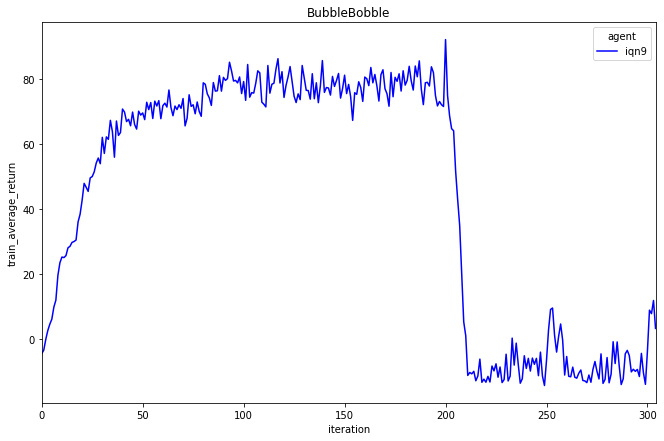

In [20]:
showRewardPerIterationGraph(['iqn9'])

## Study Case of Altari?

26.Jun.2020
1. trains DQN with all altari games (like 2000) => evaluate each games?
2. train and evaluate each game one by one.
* 440 -> train from 1 to 50 by 1 in sequence. 440 i = 11 level. 441 i = 12 l. 442 = 13.... 50 level -> 1 level.
* 1 episode per 1 level. then select random level. (from next-monday) => make clone to IQN9.
* Next Meeting on Monday @9PM
* Brief Overview presention. google sheet to share. (3 MIN).
* @victor. make jupyter notebook for competition with level + reward display.